# Subset Rectangles

Create rectangular covering for coastline buffer. To be used for subsetting Sentinel-2 images, for indexing areas by grid tiles for training/validation/testing.

## Setup

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import geopandas as gpd
import contextily as cx

In [4]:
import mgrs

In [5]:
from shapely.geometry import MultiPolygon, Polygon, Point, box

In [6]:
from shapely.ops import unary_union

In [7]:
import shapely.wkt

In [8]:
DATA_DIR = '../data/'
FIGURES_DIR = '../saved_figures/'

## Coastline buffer

In [9]:
tileId = '30UUA'

In [10]:
wkt_fp = os.path.join(DATA_DIR, f'coastline_buffer/Buffered_Coastline_{tileId}.wkt')

In [11]:
with open(wkt_fp, 'r') as f:
    wkt = f.read()

In [12]:
poly = gpd.GeoSeries.from_wkt([wkt])

## Land polygons

In [52]:
land_fp = os.path.join(DATA_DIR, 'simplified-land-polygons-complete-3857/simplified_land_polygons.shp')
land_polys = gpd.read_file(land_fp)

In [53]:
land_polys = land_polys.to_crs("EPSG:32630")

## Rectangle covering - metric coordinates method

In [54]:
import math

In [55]:
def min_max_round(array, step_size):
    res = np.zeros(4)
    res[0] = int(math.floor(array[0] / step_size)) * step_size
    res[1] = int(math.floor(array[1] / step_size)) * step_size
    res[2] = int(math.ceil(array[2] / step_size)) * step_size
    res[3] = int(math.ceil(array[3] / step_size)) * step_size
    return res

In [56]:
# Sentinel-2 Sub-tile Size in EPSG:32630
STEP_SIZE = 10000  # 10.0 km in meters

def create_epsg_grid(polygon, land_df, crs="EPSG:32630"):
    """
    Generate a regular grid covering for a polygon in a given CRS.
    
    :param polygon: Shapely Polygon (buffered coastline)
    :param land_df: Land DataFrame
    :param crs: Target coordinate reference system (default: EPSG:32630)
    :return: List of intersecting tile bounding boxes
    """
    # Reproject polygon to EPSG:32630
    geometry = polygon.geometry.iloc[0]
    if isinstance(geometry, MultiPolygon):
        polygons = list(geometry.geoms)
    else:
        polygons = geometry
    
    gdf_polygons = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326").to_crs(crs)
    polygons_utm = list(gdf_polygons.geometry)

    # Get bounds in UTM coordinates
    minx, miny, maxx, maxy = min_max_round(gdf_polygons.total_bounds, step_size=STEP_SIZE)

    # Generate grid cells at Sentinel-2 tile resolution
    grid_boxes = []
    x_coords = np.arange(minx, maxx, STEP_SIZE)
    y_coords = np.arange(miny, maxy, STEP_SIZE)

    for x in x_coords:
        for y in y_coords:
            tile = box(x, y, x + STEP_SIZE, y + STEP_SIZE)

            # Check if tile intersects the coastline polygon
            if any(p.intersects(tile) for p in polygons_utm):
                # Exclude tiles that are entirely on land
                if not land_df.to_crs(crs).contains(tile).any():
                    grid_boxes.append(tile)

    return grid_boxes, polygons_utm

In [57]:
# Get intersecting tiles in EPSG:32630
tile_boxes, polygons_utm = create_epsg_grid(poly, land_polys)

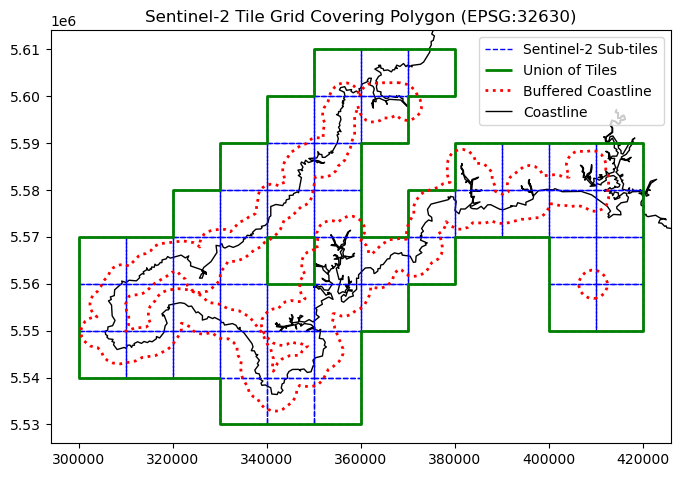

In [58]:
# Compute the union of all intersecting tiles
union_polygon = unary_union(tile_boxes)

# Convert to GeoDataFrame for plotting
gdf_tiles = gpd.GeoDataFrame(geometry=tile_boxes, crs="EPSG:32630")
gdf_union = gpd.GeoDataFrame(geometry=[union_polygon], crs="EPSG:32630")
gdf_polygon = gpd.GeoDataFrame(geometry=polygons_utm, crs="EPSG:32630")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_tiles.boundary.plot(ax=ax, color="blue", linewidth=1, linestyle="--", label="Sentinel-2 Sub-tiles")
gdf_union.boundary.plot(ax=ax, color="green", linewidth=2, label="Union of Tiles")
gdf_polygon.boundary.plot(ax=ax, color="red", linewidth=2, linestyle=":", label="Buffered Coastline")

# Plot land without changing axes
xlim, ylim = ax.get_xlim(), ax.get_ylim()
land_polys.boundary.plot(ax=ax, color="black", linewidth=1, zorder=1, label="Coastline")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Labels & Legend
ax.set_title("Sentinel-2 Tile Grid Covering Polygon (EPSG:32630)")
ax.legend()
# plt.savefig(os.path.join(FIGURES_DIR, 's2_polygon_covering'))
plt.show()

In [59]:
tiles_wkt = [p.wkt for p in gdf_tiles.geometry]

## Rectangle covering - all MGRS tiles

In [13]:
utm_year_fp = pd.read_csv(os.path.join(DATA_DIR, 'utm_years.csv'))

In [14]:
mgrs_tiles = utm_year_fp['utm_tile'].unique()

In [15]:
mgrs_tiles

array(['29UPB', '29UMV', '29UNT', '29UPT', '29UNA', '29UNB', '29UMT',
       '29UMU', '29UMA', '29UPV', '32VNL', '32VNK', '32VPK', '32VMK',
       '32VNR', '32VLP', '32VPL', '32VLQ', '32VPJ', '33VUC', '32VMH',
       '32VNJ', '32VMJ', '32VNH', '32UMG', '32UMH', '32UNF', '32UMF',
       '32UPG', '32UPH', '33UUC', '33UUB', '32VPH', '32UNG', '32UNH',
       '32UPF', '33UUA', '33UVB', '33UVA', '27WVM', '27WVN', '32UME',
       '32ULE', '31UET', '31UES', '31UFV', '30UXV', '30TXP', '30UWV',
       '30TWT', '30UUU', '30UVV', '30UWU', '30UVU', '30TVT', '30TWS',
       '30TVU', '30UXA', '30VWJ', '30VVJ', '29VPC', '29VND', '30VUH',
       '29VPD', '30VUJ', '30VWH', '30UUG', '30UUH', '30VXN', '30VXM',
       '30VWM', '29VPF', '30VUL', '30VWL', '30VVL', '29VNE', '29VPE',
       '30VUK', '30VVK', '30UWG', '30UVF', '30VVH', '30UUF', '29UPR',
       '30UUA', '30UUB', '30UTA', '30UVA', '30UWB', '30UVB', '30UXB',
       '30UXE', '30UXF', '31UCS', '30UXG', '30UVC', '30UUC', '30UVD',
       '30UUD', '30U

Priority tiles

In [16]:
priority_tiles = ['29UPR', '30UUA', '30UVA', '30UVB', '30UWB', '30UXA', '30UVB', '30UVC', '30UUC', '30UUD', '30UUE', '30UVE', '30UUF', '30UVF', '30UUG', '29UPB', '30VUH', '30VUJ', '30VUK', '30VVK', '30VVL', '30VWL', '29VPC', '29VPD', '29VPE',
                  '32UMF', '32UNF', '32UNG', '32UPF', '32UPG', '32VPK']

In [18]:
len(mgrs_tiles)

104

In [19]:
len(priority_tiles)

31

In [26]:
tiles_wkt_dict = dict()

In [27]:
for tileId in priority_tiles:
    wkt_fp = os.path.join(DATA_DIR, f'coastline_buffer/Buffered_Coastline_{tileId}.wkt')
    if os.path.exists(wkt_fp):
        with open(wkt_fp, 'r') as f:
            wkt = f.read()
    poly = gpd.GeoSeries.from_wkt([wkt])
    
    tile_boxes, polygons_utm = create_epsg_grid(poly, land_polys)
    tiles_gdf = gpd.GeoDataFrame(geometry=tile_boxes, crs="EPSG:32630").to_crs("EPSG:4326")
    tiles_wkt = [p.wkt for p in tiles_gdf.geometry]

    tiles_wkt_dict[tileId] = tiles_wkt

In [28]:
import json

In [29]:
with open(os.path.join(DATA_DIR, 'tile_buffer_wkt.json'), 'w') as f:
    json.dump(tiles_wkt_dict, f)

In [30]:
with open(os.path.join(DATA_DIR, 'tile_buffer_wkt.json'), 'r') as f:
    tiles_wkt_dict = json.load(f)

In [31]:
tiles_wkt_dict

{'29UPR': ['POLYGON ((-6.472910058321965 49.78036682489431, -6.479351130610527 49.87014441009097, -6.618237499916473 49.86588784150236, -6.611540655688569 49.77612367639193, -6.472910058321965 49.78036682489431))',
  'POLYGON ((-6.479351130610527 49.87014441009097, -6.485824670429968 49.959919983166095, -6.624968093444542 49.95564994500671, -6.618237499916473 49.86588784150236, -6.479351130610527 49.87014441009097))',
  'POLYGON ((-6.334247204555051 49.78444433785166, -6.3404322940910625 49.874234821485175, -6.479351130610527 49.87014441009097, -6.472910058321965 49.78036682489431, -6.334247204555051 49.78444433785166))',
  'POLYGON ((-6.3404322940910625 49.874234821485175, -6.346648567484521 49.96402334057948, -6.485824670429968 49.959919983166095, -6.479351130610527 49.87014441009097, -6.3404322940910625 49.874234821485175))',
  'POLYGON ((-6.346648567484521 49.96402334057948, -6.352896229115786 50.05380989202813, -6.492330890501183 50.049693540683585, -6.485824670429968 49.959919983

In [32]:
tiles_wkt = tiles_wkt_dict['30UUA']

In [33]:
gdf_tiles = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkt(tiles_wkt), crs="EPSG:4326").to_crs("EPSG:32630")

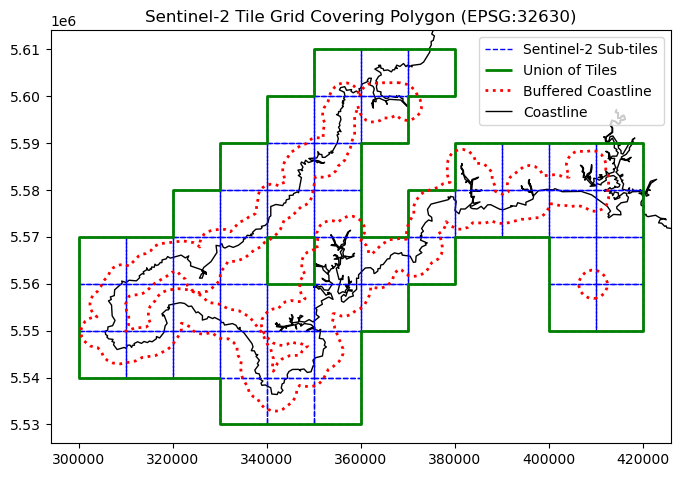

In [60]:
# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_tiles.boundary.plot(ax=ax, color="blue", linewidth=1, linestyle="--", label="Sentinel-2 Sub-tiles")
gdf_union.boundary.plot(ax=ax, color="green", linewidth=2, label="Union of Tiles")
gdf_polygon.boundary.plot(ax=ax, color="red", linewidth=2, linestyle=":", label="Buffered Coastline")

# Plot land without changing axes
xlim, ylim = ax.get_xlim(), ax.get_ylim()
land_polys.boundary.plot(ax=ax, color="black", linewidth=1, zorder=1, label="Coastline")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Labels & Legend
ax.set_title("Sentinel-2 Tile Grid Covering Polygon (EPSG:32630)")
ax.legend()
plt.show()